In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
import tensorflow.keras as keras
from tqdm import tqdm
#import webrtcvad
import librosa.display
import os
%matplotlib inline

TRAIN_TARGETS_PATH = 'data/train/targets.tsv'
TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'

SR = 16000
BYTES_MULTIPLICATOR = 32767


def input_gate():
    input_str = input('Введите да, если хотите выполнить ячейку: ')
    if input_str.lower() != 'да':
        raise Exception('Операция отклонена')

# Загрузка имен файлов и меток

In [2]:
a_df = pd.read_csv(TRAIN_TARGETS_PATH, sep='\t', names=['name', 'target'])
a_df.head()

,name,target
0,5d1f7e43366513a1d0a6ec5640c3dc24,1
1,9a701a4536a05b6610a590a9fe702ed8,1
2,cad0b8547008d1524c1a0e5fd51f9908,1
3,4bbe607e7dc95460e2cc1a6ee5f4dfa6,0
4,30fb32cba90b34af26f3f14f5d636805,0


#### Доли классов

In [3]:
a_df.target.value_counts() / len(a_df)

0    0.546785
1    0.453215
Name: target, dtype: float64

# Препроцессинг файлов

In [4]:
def load_file(path):
    return librosa.load(path, sr=SR)[0]


def ms_to_n(n_ms):
    return n_ms * SR // 10**3


def split_into_windows(wave, n_ms, step='full'):
    if n_ms != 10 and n_ms != 20 and n_ms != 30:
        raise ValueError('n_ms может быть равным только 10, 30 или 40')
    frame_size = ms_to_n(n_ms)
    if step == 'full':
        step = frame_size
    return np.vstack(wave[i : i + frame_size] for i in range(0, wave.shape[0] - frame_size + 1, step))
    

def mask_windows(windows, mode):
    '''
    Если изменится sample rate, замени np.int16
    на соответствующий вариант!
    '''
    vad = webrtcvad.Vad(mode)
    mask = np.empty(windows.shape[0], dtype='bool')
    for i in range(mask.shape[0]):
        mask[i] = vad.is_speech(
            (windows[i] * BYTES_MULTIPLICATOR).astype(np.int16).tobytes(), SR
        )
    return mask


def filtered_plot(windows, windows_mask):
    frame_size = windows.shape[1]
    for i in range(len(windows)):
        plt.plot(np.arange(i * frame_size, (i + 1) * frame_size),
                 windows[i], c=('red' if mask[i] else 'blue'))

        
def basic_preprocess(filenames, tracks_path, windows_path,
                     masks_path, filtered_windows_path,
                     n_ms=30, step='full', mode=3):    
    for filename in tqdm(filenames):
        wave = load_file(tracks_path + filename + '.wav')
        windows = split_into_windows(wave, n_ms)
        mask = mask_windows(windows, mode)
        filtered_windows = windows[mask]
        
        np.save(masks_path + 'mask_' + filename + '.npy', mask)
        np.save(windows_path + 'win_' + filename + '.npy', windows)
        np.save(filtered_windows_path + 'filt_win_' + filename + '.npy', filtered_windows)

## Избавление от тишины, сохранение полученных результатов в файлы

In [5]:
TRAIN_PREPROCESSED_PATH = 'data/train_preproc/'
TRAIN_MASK_PATH = 'data/train_preproc/masks/'
TRAIN_WINDOWS_PATH = 'data/train_preproc/windows/'
TRAIN_FILTERED_WINDOWS_PATH = 'data/train_preproc/filtered_windows/'
n_ms = 30

input_gate()
    
basic_preprocess(a_df.name.values,
                 TRAIN_PATH,
                 TRAIN_WINDOWS_PATH,
                 TRAIN_MASK_PATH,
                 TRAIN_FILTERED_WINDOWS_PATH,
                 n_ms=n_ms)

Введите да, если хотите выполнить ячейку:  gsfgsdgdsfgs


Exception: Операция отклонена

In [6]:
test_names = list(map(lambda s: s[:-4], os.listdir('data/test')))
test_names[:10]

['00100026dbdffcd01cde6ee9b9a9d273',
 '0014278276a6cc05fe8c522af0a677df',
 '0026e20266ceba9cdda2c116e89d2f3b',
 '008b37fc832d3dfad9105961c5801c02',
 '00b1d7d0d6fdb25050041f6e2ae2871e',
 '00b23e5cbc6f652b55d0754ed5ce300f',
 '00d314de185e2e2425590e18e88c969f',
 '00d9d606720bf95d08546c4bcb19ba71',
 '00f3de3001b7f177384897278f905f83',
 '0113ca85c57aeafd828acc1e765c058b']

In [7]:
TEST_PREPROCESSED_PATH = 'data/test_preproc/'
TEST_MASK_PATH = 'data/test_preproc/masks/'
TEST_WINDOWS_PATH = 'data/test_preproc/windows/'
TEST_FILTERED_WINDOWS_PATH = 'data/test_preproc/filtered_windows/'
n_ms = 30

input_gate()
    
basic_preprocess(test_names,
                 TEST_PATH,
                 TEST_WINDOWS_PATH,
                 TEST_MASK_PATH,
                 TEST_FILTERED_WINDOWS_PATH,
                 n_ms=n_ms)

Введите да, если хотите выполнить ячейку:  fdgsgdgsdgsdfg


Exception: Операция отклонена

In [8]:
i = -1

In [ ]:
i += 1
name = test_names[i]
windows = np.load(TEST_WINDOWS_PATH + 'win_' + name + '.npy')
mask = np.load(TEST_MASK_PATH + 'mask_' + name + '.npy')
filtered_plot(windows, mask)

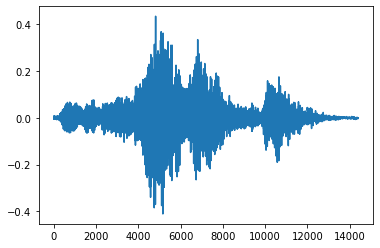

In [23]:
name = test_names[0]
fil_ex = np.load(TEST_FILTERED_WINDOWS_PATH + 'filt_win_' + name + '.npy')
plt.plot(fil_ex.ravel())

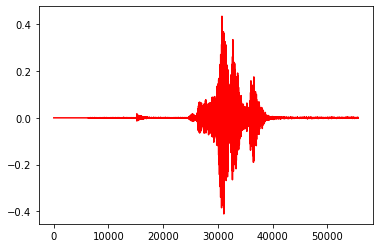

In [24]:
ex = load_file(TEST_PATH + name + '.wav')
plt.plot(ex, c='red')

## Спектрограмма

In [8]:
def spectrogram(wave, window_size, step, n_mels):
    S = librosa.feature.melspectrogram(wave, sr=SR, n_fft=window_size,
                                       hop_length=step, n_mels=n_mels)
    return librosa.power_to_db(S, ref=np.max)


def spec_plot(spec, step):
    librosa.display.specshow(spec, sr=SR, hop_length=step, x_axis='time', y_axis='mel')


def spectrogram_preprocess(filenames, waves_path, spec_path, window_size, step, n_mels, prefix=''):
    for filename in tqdm(filenames):
        try:
            wave = np.load(waves_path + prefix + filename + '.npy')
            spec = spectrogram(wave.ravel(), window_size, step, n_mels)
            np.save(spec_path + 'spec_' + filename + '.npy', spec)
        except:
            print(filename)
            np.save(spec_path + 'spec_' + filename + '.npy', np.zeros((32, 128)))

In [9]:
TRAIN_SPEC_PATH = 'data/train_preproc/specs/'


# n_ms = ?

n_mels = 128
step = 128
w_size = 512

#n_mels = 128
#step = 128
#w_size = 2048

input_gate()

filenames_for_sp = a_df.name.values
spectrogram_preprocess(filenames_for_sp,
                       TRAIN_FILTERED_WINDOWS_PATH,
                       TRAIN_SPEC_PATH,
                       w_size, step, n_mels,
                       'filt_win_')

Введите да, если хотите выполнить ячейку:  fdsgsdfgsdfg


Exception: Операция отклонена

In [10]:
TEST_SPEC_PATH = 'data/test_preproc/specs/'


# n_ms = ?

n_mels = 128
step = 128
w_size = 512

#n_mels = 128
#step = 128
#w_size = 2048

input_gate()

spectrogram_preprocess(test_names,
                       TEST_FILTERED_WINDOWS_PATH,
                       TEST_SPEC_PATH,
                       w_size, step, n_mels,
                       'filt_win_')

Введите да, если хотите выполнить ячейку:  fgdhfghfdghdfg


Exception: Операция отклонена

In [ ]:
# ecc0ab9d624ce88913aed66747aa421d - косяк

In [24]:
np.load(TEST_FILTERED_WINDOWS_PATH + 'filt_win_' + test_names[961] + '.npy').ravel().shape

(11520,)

# Загрузка очищенных данных

In [11]:
def load_all_specs(spec_path, filenames):
    res = list()
    for fname in tqdm(filenames):
        spec = np.load(spec_path + 'spec_' + fname + '.npy')
        res.append(spec)
    return res


def transpose_all(seqs):
    return [elem.T for elem in seqs]

In [12]:
n_feat = 128
n_feat

128

In [13]:
X_train = transpose_all(load_all_specs(TRAIN_SPEC_PATH, a_df.name.values))

100%|███████████████████████████████████████████████████████████████████████████| 13936/13936 [01:42<00:00, 136.42it/s]


#### split train

In [14]:
FIRST_PART_SIZE = 10000

In [15]:
X_train_1 = X_train[:FIRST_PART_SIZE]
X_train_2 = X_train[FIRST_PART_SIZE:]

#### Распределение длительностей спектрограмм

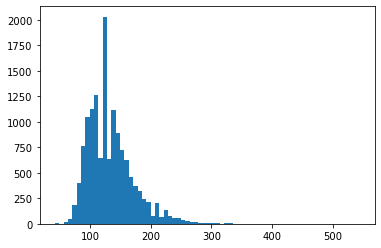

In [16]:
%matplotlib inline
plt.hist([elem.shape[0] for elem in X_train], bins=70);

#### example

In [17]:
a_df.name.values[3569]

'f47834a8b6f7d08e7001a5b98f1e3867'

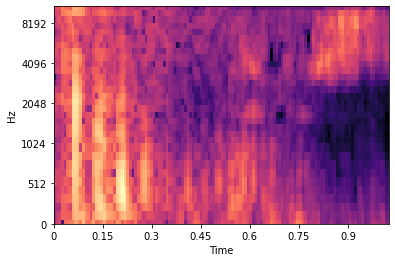

In [18]:
spec_plot(X_train[3569][:32,:], step=128)

# LSTM

#### split padded

In [16]:
X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train, padding='post', value=1)

In [17]:
X_train_padded_1 = X_train_padded[:FIRST_PART_SIZE]
X_train_padded_2 = X_train_padded[FIRST_PART_SIZE:]

In [18]:
model = keras.Sequential([
    keras.layers.Masking(mask_value=1, input_shape=(None, n_feat)),
    keras.layers.LSTM(64, activation='tanh', return_sequences=True),
    #keras.layers.TimeDistributed(keras.layers.Dense(128, activation='sigmoid')),
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation='sigmoid')),
    keras.layers.GlobalAveragePooling1D()
])

In [19]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [20]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          49408     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           65        
_________________________________________________________________
global_average_pooling1d (Gl (None, 1)                 0         
Total params: 49,473
Trainable params: 49,473
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(x=X_train_padded_1, y=a_df.target.values[:FIRST_PART_SIZE], epochs=6)

Epoch 1/6
313/313 [==============================] - 89s 284ms/step - loss: 0.1837 - accuracy: 0.9537
Epoch 2/6
313/313 [==============================] - 93s 297ms/step - loss: 0.1763 - accuracy: 0.9567
Epoch 3/6
313/313 [==============================] - 89s 284ms/step - loss: 0.1682 - accuracy: 0.9586
Epoch 4/6
313/313 [==============================] - 89s 283ms/step - loss: 0.1704 - accuracy: 0.9563
Epoch 5/6
313/313 [==============================] - 88s 282ms/step - loss: 0.1620 - accuracy: 0.9585
Epoch 6/6
313/313 [==============================] - 89s 285ms/step - loss: 0.1619 - accuracy: 0.9589


#### Accuracy

In [25]:
metric = keras.metrics.Accuracy()
metric.update_state(model.predict_classes(X_train_padded_2), a_df.target.values[FIRST_PART_SIZE:])
metric.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9636687>

In [29]:
input_gate()

model.save('spbu_models/lstm.h5', save_format="h5")

Введите да, если хотите выполнить ячейку:  да


# Разбиение на окна

In [16]:
def split_into_windows2(a, w_size=32, step=32):
    return np.array([a[i : i + w_size] for i in range(0, a.shape[0] - w_size + 1, step)])

In [17]:
X_splited = [split_into_windows2(elem, 32, 32) for elem in X_train]

#### Определяем target для каждого окна

In [18]:
y_for_windows = list()
for i, elem in enumerate(X_splited):
    y_for_windows.extend([a_df.target[i]] * len(elem))
y_for_windows = np.array(y_for_windows).reshape(-1, 1)

In [19]:
np.min([elem.shape[0] for elem in X_splited])

1

#### train-test split

In [20]:
X_splited_1 = X_splited[:FIRST_PART_SIZE]
X_splited_2 = X_splited[FIRST_PART_SIZE:]
y_for_windows_1 = y_for_windows[:np.sum(np.fromiter((elem.shape[0] for elem in X_splited_1), np.int32))]
y_for_windows_2 = y_for_windows[y_for_windows_1.shape[0]:]

# CNN2

In [37]:
model = keras.models.Sequential([
    keras.layers.Reshape((32, 128, 1), input_shape=(32, 128)),
    keras.layers.Conv2D(64, 4, (4, 4), input_shape=(32, 128, 1), activation='selu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    keras.layers.Conv2D(64, 4, (4, 4), activation='selu'),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [38]:
optimizer = keras.optimizers.Adam(learning_rate=0.000001)

In [39]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 64)         1088      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 8, 64)          65600     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
__________________________________________________

In [77]:
model.fit(x=np.vstack(X_splited_1), y=y_for_windows_1, epochs=20)

Epoch 1/20
1154/1154 [==============================] - 23s 20ms/step - loss: 0.1983 - accuracy: 0.9317
Epoch 2/20
1154/1154 [==============================] - 23s 20ms/step - loss: 0.1981 - accuracy: 0.9308
Epoch 3/20
1154/1154 [==============================] - 23s 20ms/step - loss: 0.1980 - accuracy: 0.9320
Epoch 4/20
1154/1154 [==============================] - 23s 20ms/step - loss: 0.1977 - accuracy: 0.9315
Epoch 5/20
1154/1154 [==============================] - 24s 21ms/step - loss: 0.1975 - accuracy: 0.9319
Epoch 6/20
1154/1154 [==============================] - 23s 20ms/step - loss: 0.1975 - accuracy: 0.9318
Epoch 7/20
1154/1154 [==============================] - 23s 20ms/step - loss: 0.1971 - accuracy: 0.9320
Epoch 8/20
1154/1154 [==============================] - 22s 19ms/step - loss: 0.1972 - accuracy: 0.9318
Epoch 9/20
1154/1154 [==============================] - 22s 19ms/step - loss: 0.1968 - accuracy: 0.9324
Epoch 10/20
1154/1154 [==============================] - 22s 19m

#### Accuracy

In [79]:
y_pred = model.predict(np.vstack(X_splited_2))

y_pred2 = np.empty(len(X_splited_2))
b = 0
for i in range(len(X_splited_2)):
    y_pred2[i] = np.mean(y_pred[b : b + X_splited_2[i].shape[0]])
    b += X_splited_2[i].shape[0]

accuracy = keras.metrics.Accuracy()
accuracy.update_state(a_df.target.values[FIRST_PART_SIZE:],
                      (y_pred2.reshape(-1, 1) > 0.5).astype(int))
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9669715>

In [80]:
input_gate()

model.save('spbu_models/cnn')

Введите да, если хотите выполнить ячейку:  да


INFO:tensorflow:Assets written to: spbu_models/cnn\assets


In [61]:
X_test = transpose_all(load_all_specs(TEST_SPEC_PATH, test_names))

100%|██████████████████████████████████████████████████████████████████████████████| 3413/3413 [00:50<00:00, 68.07it/s]


In [62]:
X_test_splited = [split_into_windows2(elem, 32, 32) for elem in X_test]

In [69]:
X_test_splited[964] = X_test_splited[0]
X_test_splited[3147] = X_test_splited[0]

In [70]:
y_pred_test = model.predict(np.vstack(X_test_splited))

In [71]:
y_pred_test2 = np.empty(len(test_names))
b = 0
for i in range(len(X_test_splited)):
    y_pred_test2[i] = np.mean(y_pred_test[b : b + X_test_splited[i].shape[0]])
    b += X_test_splited[i].shape[0]

In [76]:
y_pred_test2[0]

0.9910028576850891

In [77]:
y_test_classes = (y_pred_test2 > 0.5).astype('int32')

In [80]:
np.max(np.abs(y_test_classes - y_pred_test2))

0.499112606048584

In [75]:
y_pred_test2.shape, len(test_names)

((3413,), 3413)

In [ ]:
te

In [86]:
with open('targets.tsv', 'w') as f:
    for i in range(len(test_names)):
        f.write(test_names[i] + '\t' + str(y_test_classes[i]) + '\n')

In [87]:
test_names[0]

'00100026dbdffcd01cde6ee9b9a9d273'

In [ ]:
# 1 - женщ
# 0 - муж

In [104]:
y_pred_test2

array([0.99100286, 0.96601558, 0.84717518, ..., 0.47930107, 0.02227749,
       0.45166531])

# LSTM2

In [47]:
rnn = keras.models.Sequential([
    keras.layers.Bidirectional(
        keras.layers.LSTM(64), input_shape=(32, 128)
    ),
    keras.layers.Dense(1, activation='sigmoid')
])

In [52]:
optimizer = keras.optimizers.Adam(learning_rate=0.000001)

In [53]:
rnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
rnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 98,945
Trainable params: 98,945
Non-trainable params: 0
_________________________________________________________________


In [55]:
rnn.fit(x=np.vstack(X_splited), y=y_for_windows, epochs=3)

Epoch 1/3
1610/1610 [==============================] - 52s 30ms/step - loss: 0.2957 - accuracy: 0.8899
Epoch 2/3
1610/1610 [==============================] - 56s 35ms/step - loss: 0.3002 - accuracy: 0.8870
Epoch 3/3
1610/1610 [==============================] - 53s 33ms/step - loss: 0.2911 - accuracy: 0.8885


In [62]:
y_pred = rnn.predict(np.vstack(X_splited))

In [63]:
y_pred2 = np.empty(len(a_df))
b = 0
for i in range(len(X_splited)):
    y_pred2[i] = np.mean(y_pred[b : b + X_splited[i].shape[0]])
    b += X_splited[i].shape[0]

In [64]:
accuracy = keras.metrics.Accuracy()

In [65]:
accuracy.update_state(a_df[['target']].values,
                      (y_pred2.reshape(-1, 1) > 0.5).astype(int))

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=13936.0>

In [66]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9449627>

# AutoEncoder

In [75]:
e = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(32, 128, 1)),
    keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')
])

In [77]:
e.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 32, 128, 16)       160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 64, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 64, 8)         1160      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 32, 8)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 32, 8)          584       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 16, 8)          0         
Total params: 1,904
Trainable params: 1,904
Non-trainable params: 0
___________________________________________________

In [85]:
d = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(4, 16, 8)),
    keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(1, (3, 3), padding='same'),
    keras.layers.Reshape((32, 128))
])

In [86]:
d.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 4, 16, 8)          584       
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 8, 32, 8)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 8, 32, 8)          584       
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 16, 64, 8)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 64, 16)        1168      
_________________________________________________________________
up_sampling2d_17 (UpSampling (None, 32, 128, 16)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 128, 1)      

In [87]:
ae = keras.models.Sequential(
    e,
    d
)

In [88]:
ae_optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [89]:
ae.compile(loss='mse')

In [ ]:
ae.fit(x=np.vstack(X_splited), y=np.vstack(X_splited))

# CNN(плохой вариант)

In [11]:
model = keras.models.Sequential([
    keras.layers.Reshape((32, 128, 1), input_shape=(32, 128)),
    keras.layers.Conv2D(64, 4, (4, 4), input_shape=(32, 128, 1)),
    keras.layers.Conv2D(64, 4, (4, 4)),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 32, 64)         1088      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 8, 64)          65600     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [13]:
loss = keras.losses.get('binary_crossentropy')

In [14]:
optimizer = keras.optimizers.RMSprop()

In [15]:
metric = keras.metrics.Accuracy()

In [71]:
metric.update_state([[1]], [[1]])

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>

In [72]:
metric.result()

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [73]:
metric.reset_state()

#### Train loop

In [28]:
batch_size = 16
n_epochs = 1

for epoch in range(n_epochs):
    print('epoch = ', epoch)
    for i in tqdm(range(len(X_splited) // batch_size)):
        batch_X = X_splited[i*batch_size : (i+1)*batch_size]
        batch_y = a_df[['target']].values[i*batch_size : (i+1)*batch_size]
        with tf.GradientTape() as tape:
            tl = tf.Variable(0.0)
            for sample, sample_y, s_i in zip(batch_X, batch_y, range(batch_size)):
                ans = model(sample, training=True)
                l = tf.reduce_mean(
                        loss(tf.reduce_mean(ans, keepdims=True),
                             sample_y.astype('float32').reshape(-1, 1)))
                tl = tl + l / batch_size
                
        grad = tape.gradient(tl, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables))

  0%|          | 1/871 [00:00<02:42,  5.37it/s]

epoch =  0


100%|██████████| 871/871 [01:54<00:00,  7.61it/s]


In [31]:
model(X_splited[2])

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.]], dtype=float32)>

In [97]:
tl

<tf.Tensor: shape=(), dtype=float32, numpy=7.1542025>

In [101]:
grad.shape

AttributeError: 'list' object has no attribute 'shape'

In [28]:
tf.Variable(np.zeros(batch_size))

<tf.Variable 'Variable:0' shape=(16,) dtype=float64, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>

In [25]:
tl

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=132.68092>

In [20]:
model(X_splited[0])

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.99992967],
       [0.9999339 ],
       [0.9996873 ]], dtype=float32)>

In [26]:
tf.reduce_mean(model(X_splited[0]), keepdims=True)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9998503]], dtype=float32)>

In [29]:
loss(tf.reduce_mean(model(X_splited[0]), keepdims=True), np.array([[0.0]]))

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([10.84200769])>

In [36]:
a_df[['target']].values[0*16 : (0+1)*16]

array([[1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0]])